In [29]:
import numpy as np
import math
import gtsam
from perseus.smoother.factors import PoseDynamicsFactor, ConstantVelocityFactor
import json
from gtsam.symbol_shorthand import X, V, W
import gtsam_unstable
import kornia
import time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Quick example: 3D pose estimation with constant twist scenario.


# Setup scenario.
vel = np.array([0.1, 0, 0])
ang_vel = np.array([math.radians(30), -math.radians(30), 0])
vel_cov = np.array([1e-1, 1e-1, 1e-1])
ang_vel_cov = np.array([1e-1, 1e-1, 1e-1])
noisy_vel = vel + np.sqrt(vel_cov) * np.random.randn(3)
noisy_ang_vel = ang_vel + np.sqrt(ang_vel_cov) * np.random.randn(3)

# Create random initial pose.
prior_cov = np.diag(np.array([1e-1, 1e-1, 1e-1, 1e0, 1e0, 1e0]))
init_pose = gtsam.Pose3().expmap(np.linalg.cholesky(prior_cov) @ np.random.randn(6))

# Create process and measurement noises.
process_noise_pose = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3]))
process_noise_vel = gtsam.noiseModel.Diagonal.Sigmas(1e-1 * vel_cov)
process_noise_ang_vel = gtsam.noiseModel.Diagonal.Sigmas(1e-1 * ang_vel_cov)
meas_noise = gtsam.noiseModel.Diagonal.Sigmas(1e1 * np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1]))

# Create scenario.
scenario = gtsam.ConstantTwistScenario(noisy_ang_vel, noisy_vel, init_pose)
dt = 1e-1
n_steps = 10

# Create a factor graph
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Create ISAM.
parameters = gtsam.ISAM2Params()
isam = gtsam.ISAM2(parameters)

# Create a prior on the initial position
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.diag(prior_cov))
graph.push_back(gtsam.PriorFactorPose3(X(0), gtsam.Pose3(), prior_noise))

# Create a prior on the initial velocity
prior_velocity = gtsam.noiseModel.Diagonal.Sigmas(vel_cov)
graph.push_back(gtsam.PriorFactorVector(V(0), vel, prior_velocity))

# Create a prior on the initial angular velocity
prior_angular_velocity = gtsam.noiseModel.Diagonal.Sigmas(ang_vel_cov)
graph.push_back(gtsam.PriorFactorVector(W(0), ang_vel, prior_angular_velocity))

# Initialize values with the prior.
initial_estimate.insert(X(0), init_pose)
initial_estimate.insert(V(0), vel)
initial_estimate.insert(W(0), ang_vel)

# Solve to check we can recover the prior.
isam.update(graph, initial_estimate)
result = isam.calculateEstimate()
initial_estimate.clear()

def add_factors(graph, initial_estimate, ii):
    curr_time = ii * dt

    # Simulate dynamics.
    pose = scenario.pose(curr_time)

    # Add a random measurement.
    noisy_pose = pose.compose(gtsam.Pose3().expmap(np.sqrt(meas_noise.sigmas()) * np.random.randn(6)))

    # Update the initial values.
    initial_estimate.insert(X(ii), noisy_pose)
    initial_estimate.insert(V(ii), result.atVector(V(ii-1)))
    initial_estimate.insert(W(ii), result.atVector(W(ii-1)))

    # Create a dynamics factor and add it to the graph.
    dynamics_factor = PoseDynamicsFactor(process_noise_pose, X(ii-1), V(ii-1), W(ii-1), X(ii), dt)
    graph.push_back(dynamics_factor)

    # Create a constant velocity factor and add it to the graph.
    velocity_factor = ConstantVelocityFactor(process_noise_vel, V(ii-1), V(ii))
    graph.push_back(velocity_factor)

    # Create a constant angular velocity factor and add it to the graph.
    angular_velocity_factor = ConstantVelocityFactor(process_noise_ang_vel, W(ii-1), W(ii))
    graph.push_back(angular_velocity_factor)

    # Create a measurement factor and add it to the graph.
    meas_factor = gtsam.PriorFactorPose3(X(ii), noisy_pose, meas_noise)
    graph.push_back(meas_factor)

# Run loop to simulate the scenario.
for ii in range(1, n_steps):
    
    # Add new factors to graph
    %time add_factors(graph, initial_estimate, ii)

    # # Update the ISAM.
    %time isam.update(graph, initial_estimate)
    %time result = isam.calculateEstimate()
    initial_estimate.clear()
    


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. gtsam.gtsam.CustomFactor()
    2. gtsam.gtsam.CustomFactor(noiseModel: gtsam.gtsam.noiseModel.Base, keys: std::vector<unsigned long, std::allocator<unsigned long> >, errorFunction: Callable[[gtsam.gtsam.CustomFactor, gtsam.gtsam.Values, gtsam.gtsam.JacobianVector], numpy.ndarray[numpy.float64[m, 1]]])

Invoked with: 8646911284551352321, [isotropic dim=6 sigma=0.001
, 8646911284551352320, 8502796096475496448, 8574853690513424384], functools.partial(<function PoseDynamicsFactor.error_func at 0x7fd181103760>, dt=0.1)

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

CPU times: user 53 µs, sys: 89 µs, total: 142 µs
Wall time: 148 µs
CPU times: user 11 µs, sys: 18 µs, total: 29 µs
Wall time: 33.1 µs


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. gtsam.gtsam.CustomFactor()
    2. gtsam.gtsam.CustomFactor(noiseModel: gtsam.gtsam.noiseModel.Base, keys: std::vector<unsigned long, std::allocator<unsigned long> >, errorFunction: Callable[[gtsam.gtsam.CustomFactor, gtsam.gtsam.Values, gtsam.gtsam.JacobianVector], numpy.ndarray[numpy.float64[m, 1]]])

Invoked with: 8646911284551352322, [isotropic dim=6 sigma=0.001
, 8646911284551352321, 8502796096475496449, 8574853690513424385], functools.partial(<function PoseDynamicsFactor.error_func at 0x7fd181103760>, dt=0.1)

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

CPU times: user 152 µs, sys: 0 ns, total: 152 µs
Wall time: 157 µs
CPU times: user 34 µs, sys: 0 ns, total: 34 µs
Wall time: 38.1 µs


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. gtsam.gtsam.CustomFactor()
    2. gtsam.gtsam.CustomFactor(noiseModel: gtsam.gtsam.noiseModel.Base, keys: std::vector<unsigned long, std::allocator<unsigned long> >, errorFunction: Callable[[gtsam.gtsam.CustomFactor, gtsam.gtsam.Values, gtsam.gtsam.JacobianVector], numpy.ndarray[numpy.float64[m, 1]]])

Invoked with: 8646911284551352323, [isotropic dim=6 sigma=0.001
, 8646911284551352322, 8502796096475496450, 8574853690513424386], functools.partial(<function PoseDynamicsFactor.error_func at 0x7fd181103760>, dt=0.1)

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

CPU times: user 89 µs, sys: 0 ns, total: 89 µs
Wall time: 93.5 µs
CPU times: user 28 µs, sys: 0 ns, total: 28 µs
Wall time: 31.2 µs


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. gtsam.gtsam.CustomFactor()
    2. gtsam.gtsam.CustomFactor(noiseModel: gtsam.gtsam.noiseModel.Base, keys: std::vector<unsigned long, std::allocator<unsigned long> >, errorFunction: Callable[[gtsam.gtsam.CustomFactor, gtsam.gtsam.Values, gtsam.gtsam.JacobianVector], numpy.ndarray[numpy.float64[m, 1]]])

Invoked with: 8646911284551352324, [isotropic dim=6 sigma=0.001
, 8646911284551352323, 8502796096475496451, 8574853690513424387], functools.partial(<function PoseDynamicsFactor.error_func at 0x7fd181103760>, dt=0.1)

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

CPU times: user 34 µs, sys: 54 µs, total: 88 µs
Wall time: 93.9 µs
CPU times: user 11 µs, sys: 17 µs, total: 28 µs
Wall time: 30.3 µs


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. gtsam.gtsam.CustomFactor()
    2. gtsam.gtsam.CustomFactor(noiseModel: gtsam.gtsam.noiseModel.Base, keys: std::vector<unsigned long, std::allocator<unsigned long> >, errorFunction: Callable[[gtsam.gtsam.CustomFactor, gtsam.gtsam.Values, gtsam.gtsam.JacobianVector], numpy.ndarray[numpy.float64[m, 1]]])

Invoked with: 8646911284551352325, [isotropic dim=6 sigma=0.001
, 8646911284551352324, 8502796096475496452, 8574853690513424388], functools.partial(<function PoseDynamicsFactor.error_func at 0x7fd181103760>, dt=0.1)

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

CPU times: user 83 µs, sys: 0 ns, total: 83 µs
Wall time: 86.8 µs
CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 31.7 µs


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. gtsam.gtsam.CustomFactor()
    2. gtsam.gtsam.CustomFactor(noiseModel: gtsam.gtsam.noiseModel.Base, keys: std::vector<unsigned long, std::allocator<unsigned long> >, errorFunction: Callable[[gtsam.gtsam.CustomFactor, gtsam.gtsam.Values, gtsam.gtsam.JacobianVector], numpy.ndarray[numpy.float64[m, 1]]])

Invoked with: 8646911284551352326, [isotropic dim=6 sigma=0.001
, 8646911284551352325, 8502796096475496453, 8574853690513424389], functools.partial(<function PoseDynamicsFactor.error_func at 0x7fd181103760>, dt=0.1)

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

CPU times: user 33 µs, sys: 52 µs, total: 85 µs
Wall time: 88.9 µs
CPU times: user 12 µs, sys: 19 µs, total: 31 µs
Wall time: 33.6 µs


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. gtsam.gtsam.CustomFactor()
    2. gtsam.gtsam.CustomFactor(noiseModel: gtsam.gtsam.noiseModel.Base, keys: std::vector<unsigned long, std::allocator<unsigned long> >, errorFunction: Callable[[gtsam.gtsam.CustomFactor, gtsam.gtsam.Values, gtsam.gtsam.JacobianVector], numpy.ndarray[numpy.float64[m, 1]]])

Invoked with: 8646911284551352327, [isotropic dim=6 sigma=0.001
, 8646911284551352326, 8502796096475496454, 8574853690513424390], functools.partial(<function PoseDynamicsFactor.error_func at 0x7fd181103760>, dt=0.1)

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

CPU times: user 88 µs, sys: 0 ns, total: 88 µs
Wall time: 91.8 µs
CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 36.2 µs


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. gtsam.gtsam.CustomFactor()
    2. gtsam.gtsam.CustomFactor(noiseModel: gtsam.gtsam.noiseModel.Base, keys: std::vector<unsigned long, std::allocator<unsigned long> >, errorFunction: Callable[[gtsam.gtsam.CustomFactor, gtsam.gtsam.Values, gtsam.gtsam.JacobianVector], numpy.ndarray[numpy.float64[m, 1]]])

Invoked with: 8646911284551352328, [isotropic dim=6 sigma=0.001
, 8646911284551352327, 8502796096475496455, 8574853690513424391], functools.partial(<function PoseDynamicsFactor.error_func at 0x7fd181103760>, dt=0.1)

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

CPU times: user 89 µs, sys: 0 ns, total: 89 µs
Wall time: 93.5 µs
CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 37 µs


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. gtsam.gtsam.CustomFactor()
    2. gtsam.gtsam.CustomFactor(noiseModel: gtsam.gtsam.noiseModel.Base, keys: std::vector<unsigned long, std::allocator<unsigned long> >, errorFunction: Callable[[gtsam.gtsam.CustomFactor, gtsam.gtsam.Values, gtsam.gtsam.JacobianVector], numpy.ndarray[numpy.float64[m, 1]]])

Invoked with: 8646911284551352329, [isotropic dim=6 sigma=0.001
, 8646911284551352328, 8502796096475496456, 8574853690513424392], functools.partial(<function PoseDynamicsFactor.error_func at 0x7fd181103760>, dt=0.1)

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

CPU times: user 105 µs, sys: 0 ns, total: 105 µs
Wall time: 109 µs
CPU times: user 34 µs, sys: 0 ns, total: 34 µs
Wall time: 37.4 µs


In [25]:
import gtsam_unstable

n_steps = 500
lag = 2.0
smoother = gtsam_unstable.BatchFixedLagSmoother(lag)
new_factors = gtsam.NonlinearFactorGraph()
new_values = gtsam.Values()
new_timestamps = gtsam_unstable.FixedLagSmootherKeyTimestampMap()

# First setup the prior factors.
# Create a prior on the initial position
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.diag(prior_cov))
new_factors.push_back(gtsam.PriorFactorPose3(X(0), gtsam.Pose3(), prior_noise))

# Create a prior on the initial velocity
prior_velocity = gtsam.noiseModel.Diagonal.Sigmas(vel_cov)
new_factors.push_back(gtsam.PriorFactorVector(V(0), vel, prior_velocity))

# Create a prior on the initial angular velocity
prior_angular_velocity = gtsam.noiseModel.Diagonal.Sigmas(ang_vel_cov)
new_factors.push_back(gtsam.PriorFactorVector(W(0), ang_vel, prior_angular_velocity))

# Initialize values with the prior.
new_values.insert(X(0), gtsam.Pose3())
new_values.insert(V(0), vel)
new_values.insert(W(0), ang_vel)
new_timestamps.insert((X(0), 0.0))
new_timestamps.insert((V(0), 0.0))
new_timestamps.insert((W(0), 0.0))

pose_ests = []
measurements = []

for ii in range(1, n_steps):
    curr_time = ii * dt

    # Assign timestame to the current values.
    new_timestamps.insert((X(ii), curr_time))
    new_timestamps.insert((V(ii), curr_time))
    new_timestamps.insert((W(ii), curr_time))

    # Add new factors to graph
    # Simulate dynamics.
    pose = scenario.pose(curr_time)

    # Add a random measurement.
    noisy_pose = pose.compose(gtsam.Pose3().expmap(np.sqrt(meas_noise.sigmas()) * np.random.randn(6)))

    # Update the initial values.
    new_values.insert(X(ii), noisy_pose)
    if ii > 1:
        new_values.insert(V(ii), smoother.calculateEstimate().atVector(V(ii-1)))
        new_values.insert(W(ii), smoother.calculateEstimate().atVector(W(ii-1)))
    else:
        new_values.insert(V(ii), vel)
        new_values.insert(W(ii), ang_vel)

    # Create a dynamics factor and add it to the graph.
    dynamics_factor = PoseDynamicsFactor(process_noise_pose, X(ii-1), V(ii-1), W(ii-1), X(ii), dt)
    new_factors.push_back(dynamics_factor)

    # Create a constant velocity factor and add it to the graph.
    velocity_factor = ConstantVelocityFactor(process_noise_vel, V(ii-1), V(ii))
    new_factors.push_back(velocity_factor)

    # Create a constant angular velocity factor and add it to the graph.
    angular_velocity_factor = ConstantVelocityFactor(process_noise_ang_vel, W(ii-1), W(ii))
    new_factors.push_back(angular_velocity_factor)

    # Create a measurement factor and add it to the graph.
    meas_factor = gtsam.PriorFactorPose3(X(ii), noisy_pose, meas_noise)
    new_factors.push_back(meas_factor)

    # Update the smoother.
    %time smoother.update(new_factors, new_values, new_timestamps)
    # %time smoother.calculateEstimate().atPose3(X(ii))
    new_timestamps.clear()
    new_factors.resize(0)
    new_values.clear()

    # Store the pose estimate.
    pose_ests.append(smoother.calculateEstimate().atPose3(X(ii)))
    measurements.append(noisy_pose)



NameError: name 'prior_cov' is not defined

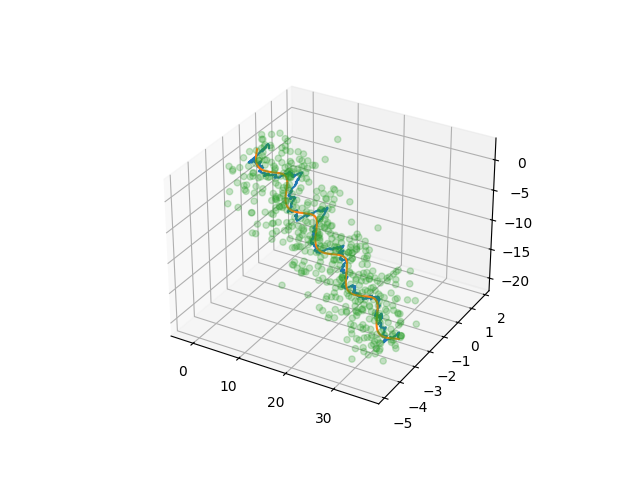

In [70]:
import matplotlib.pyplot as plt
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the ground truth.
np_pose_ests = np.array([pose_ests[ii].translation() for ii in range(len(pose_ests))])
ax.plot(np_pose_ests[:, 0], np_pose_ests[:, 1], np_pose_ests[:, 2], label='Estimated trajectory')

# Scatter the measurements
np_measurements = np.array([measurements[ii].translation() for ii in range(len(measurements))])
ax.scatter(np_measurements[:, 0], np_measurements[:, 1], np_measurements[:, 2], label='Measurements', c="C2", alpha=0.25)

# Plot the ground truth.
poses = np.array([scenario.pose(ii * dt).translation() for ii in range(n_steps)])
ax.plot(poses[:, 0], poses[:, 1], poses[:, 2], label='Ground truth trajectory')



In [9]:
from typing import List, Optional

class DynamicsFactor(gtsam.CustomFactor):
    def __init__(self, noise_model: gtsam.noiseModel, pose1: int, ang_vel1: int, vel1: int, pose2: int, dt: float):
        super().__init__(noise_model, [pose1, ang_vel1, vel1, pose2], self.error_func)
        self.dt = dt

    def error_func(self, v: gtsam.Values, H: Optional[List[np.ndarray]] = None) -> np.ndarray:
        pose1 = v.atPose3(self.keys()[0])
        ang_vel1 = v.atVector(self.keys()[1])
        vel1 = v.atVector(self.keys()[2])
        pose2 = v.atPose3(self.keys()[3])

        if H:
            perturbation_jac = np.zeros((6, 6), dtype=np.float64, order='F')

            # Case 1: JUST LOG OF pose1.
            # error = pose1.Logmap(pose1, H[0])

            # Case 2: Log of pose1.inverse.
            # pinv = pose1.inverse(H[0])
            # H1 = np.zeros((6,6), order="F")
            # error = pinv.Logmap(pinv, H1)

            # H[0] = H1 @ H[0] # Chain rule: dlog * dinv

            # Case 3: Log of pose1.between(pose2).
            # pinv = pose1.inverse(H[0])
                 # rel_pose = pose1.compose(pose2, H0, H1)
            # error = rel_pose.Logmap(rel_pose, H2)
            # error = pose1.Logmap(pose1, H[0])

            # print(H0, H1, H2)


            # H[0] = H2 @ H0
            # H[-1] = H2 @ H1
            
            dpred_dx0 = np.zeros((6,6), order="F")
            dpred_dtwist = np.zeros((6,6), order="F")
            drel_dpred = np.zeros((6,6), order="F")
            drel_dpose2 = np.zeros((6,6), order="F")

            pose_increment = pose1.Expmap(np.concatenate([dt*ang_vel1, dt*vel1]), perturbation_jac)
            pred_pose = pose1.compose(pose_increment, dpred_dx0, dpred_dtwist)

       

            rel_pose = pred_pose.between(pose2, drel_dpred, drel_dpose2)
            error = rel_pose.Logmap(rel_pose)
            dlog = rel_pose.LogmapDerivative(rel_pose)

            H[0] = dlog @ drel_dpred @ dpred_dx0
            
            derr_dtwist = dt * dlog @ drel_dpred @ dpred_dtwist @  perturbation_jac
            H[1] = derr_dtwist[:, :3]
            H[2] = derr_dtwist[:, 3:]

            H[3] = dlog @ drel_dpose2

            # error = pinv.Logmap(pinv, H[-1])

            # H[-1] = H[-1] @ H[0]

            # H[-1] = pose2.LogmapDerivative(rel_pose)
            # H[-1] = pose1.LogmapDerivative(pose1)
            return error


        

        # return error
initial_estimate = gtsam.Values()
rand_pose1 = gtsam.Pose3().expmap(np.linalg.cholesky(prior_cov) @ np.random.randn(6))
rand_pose2 = gtsam.Pose3().expmap(np.linalg.cholesky(prior_cov) @ np.random.randn(6))
rand_vel = np.random.randn(3)
rand_ang_vel = np.random.randn(3)

initial_estimate.insert(X(0), rand_pose1)
initial_estimate.insert(V(0), rand_vel)
initial_estimate.insert(W(0), rand_ang_vel)
initial_estimate.insert(X(1), rand_pose2)

# initial_estimate.insert(X(0), init_pose)
# initial_estimate.insert(X(1), init_pose.expmap(np.concatenate([dt*ang_vel, dt*vel])))
# initial_estimate.insert(V(0), vel)
# initial_estimate.insert(W(0), ang_vel)
# initial_estimate.insert(X(1), init_pose)

jac_list = [np.zeros((6,6), order="F"), np.zeros((6,3), order="F"), np.zeros((6,3), order="F"), np.zeros((6,6), order="F")]
dyn_factor = DynamicsFactor(gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1])), X(0), W(0), V(0), X(1), 1e-1)
%time gtsam_error = dyn_factor.error_func(initial_estimate, jac_list)

CPU times: user 144 µs, sys: 42 µs, total: 186 µs
Wall time: 185 µs


In [4]:
import pypose as pp
import torch

X0 = initial_estimate.atPose3(X(0))
X1 = initial_estimate.atPose3(X(1))
W0 = initial_estimate.atVector(W(0))
V0 = initial_estimate.atVector(V(0))

x0 = pp.mat2SE3(X0.matrix().astype(np.float64))
x1 = pp.mat2SE3(X1.matrix().astype(np.float64))
w0 = torch.tensor(W0.astype(np.float64))
v0 = torch.tensor(V0.astype(np.float64))
# err = pp.mat2SE3(gtsam_error.matrix().astype(np.float64))
err = torch.tensor(gtsam_error.astype(np.float64))

# x0 = pp.randn_SE3()
# x1 = pp.randn_SE3()
# w0 = torch.randn(3)
# v0 = torch.randn(3)

def flip(x):
    return torch.cat([x[3:], x[:3]])

def error(x0, w0, v0, x1, dx0, dw0, dv0, dx1):
    # return x0.Log()
    # return x0.Inv().Log()
    # return (x0 @ x1).Log()
    x0_perturbed = x0 @ pp.se3(flip(dx0)).Exp()
    v0_perturbed = v0 + dv0
    w0_perturbed = w0 + dw0
    x1_perturbed = x1 @ pp.se3(flip(dx1)).Exp()

    pred_pose = x0_perturbed @ pp.se3(dt * torch.cat([v0_perturbed, w0_perturbed])).Exp()
    rel_pose = pred_pose.Inv() @ x1_perturbed
    return flip(rel_pose.Log())
    # return (x0.Inv() @ x1).Log()
    # with pp.retain_ltype():
    #     pred_pose = x0 @ pp.se3(dt * torch.cat([v0, w0])).Exp()

    #     err = (pred_pose.Inv() @ x1).Log()

    #     return err

dx0 = torch.zeros(6, dtype=torch.float64)
dw0 = torch.zeros(3, dtype=torch.float64)
dv0 = torch.zeros(3, dtype=torch.float64)
dx1 = torch.zeros(6, dtype=torch.float64)

e = error(x0, w0, v0, x1, dx0, dw0, dv0, dx1)
e, err

# def to_gtsam(jac: torch.Tensor) -> torch.tensor:
#     flipped_inds = torch.cat((torch.arange(3,6), torch.arange(3)))
#     return jac[flipped_inds, :][:, flipped_inds]

# index = -1
# vars = [x0, w0, v0, x1]

# def adj_mat(x: pp.SE3_type) -> torch.Tensor:
#     return torch.cat([torch.cat([x.rotation().matrix(), pp.vec2skew(x.translation()) @ x.rotation().matrix()], dim=-1), torch.cat([torch.zeros_like(x.rotation().matrix()), x.rotation().matrix()], dim=-1)], dim=-2)

NameError: name 'X' is not defined

## Camera scratch

In [30]:
from perseus.smoother.factors import KeypointProjectionFactor
import torch

from perseus.detector.data import KeypointDataset, KeypointDatasetConfig
from perseus.detector.models import KeypointCNN
import pypose as pp

# Load model.
model = KeypointCNN()
model.load_state_dict(torch.load("outputs/models/02-04-24_ep70.pth"))
model.eval()

# Load data.
dataset_cfg = KeypointDatasetConfig(dataset_path="data/2024-01-12_17-21-39/mjc_data.hdf5")
dataset = KeypointDataset(dataset_cfg, train=False)
                                           

Images shape: (482, 24, 256, 256, 3)


In [107]:
# Pull random trajectory and image from the dataset.
data = dataset[0]

# Extract parameters from intrinsics.
intrinsics = data["camera_intrinsics"]
fx = intrinsics[0, 0]
fy = intrinsics[1, 1]
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]
s = 0.0

# Create a camera calibration.
calibration = gtsam.Cal3_S2(fx, fy, s, cx, cy)

# Load ground-truth keypoints.
object_scale = data["object_scale"]
keypoints_object_frame = torch.tensor(json.load(open("data/2024-01-12_17-21-39/mjc_keypoints.json"))).float() * object_scale

# Run inference to get predicted keypoints.
pred_keypoints = model(data["image"].unsqueeze(0)).squeeze(0).reshape(-1, 2)
pred_keypoints = kornia.geometry.denormalize_pixel_coordinates(pred_keypoints, model.H, model.W)
gt_keypoints = data["pixel_coordinates"].clone()

# Create noise model for the keypoint projection factor.
noise_model = gtsam.noiseModel.Isotropic.Sigma(2, 5.0)

# Create initial estimate.
initial_estimate = gtsam.Values()
object_pose = data["object_pose"].double()
camera_pose = data["camera_pose"].double()
# Convert to GTSAM pose.
PP_TO_GTSAM = pp.SE3(torch.cat((torch.zeros(3,), pp.euler2SO3(np.array([np.pi, 0, 0])).tensor())))
camera_pose = camera_pose @ PP_TO_GTSAM.Inv()

# camera_pose=pp.identity_SE3(dtype=torch.float64)

# Create a keypoint projection factor.
keypoint_factor = KeypointProjectionFactor(X(0), noise_model, calibration, pred_keypoints.detach().numpy()[0], keypoints_object_frame.numpy()[0], gtsam.Pose3(camera_pose.matrix()))

# object_pose = PP_TO_GTSAM @ camera_pose.Inv() @ object_pose 
object_pose = object_pose

initial_estimate.insert(X(0), gtsam.Pose3(object_pose.matrix()))

# Compute error.
keypoint_factor.error_func(initial_estimate, camera_intrinsics=calibration, keypoint_measurement=pred_keypoints.detach().numpy()[0], point_body_frame=keypoints_object_frame.numpy()[0], camera_pose=gtsam.Pose3(camera_pose.matrix()))

array([-7.60833625, -0.65291348])

In [28]:
initial_estimate = gtsam.Values()
initial_estimate.insert(X(0), gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0, 0, -1)))
try: 
    keypoint_factor.error_func(initial_estimate, camera_intrinsics=calibration, keypoint_measurement=pred_keypoints.detach().numpy()[0], point_body_frame=keypoints_object_frame.numpy()[0])
except RuntimeError as e:
    if e.args[0] == "CheiralityException":
        # reset filter
        pass
    else:
        raise e

ValueError: Should have thrown an exception

In [113]:
# Check Jacobians against pypose.
def flip(x):
    return torch.cat([x[3:], x[:3]])

camera_pose = data["camera_pose"].double()
object_pose = data["object_pose"].double()
camera_pose = camera_pose @ PP_TO_GTSAM.Inv()

def pypose_error(x: pp.SE3_type,  dx: torch.Tensor):
    x_perturbed = x @ pp.se3(flip(dx)).Exp()
    x_to_camera = camera_pose.Inv() @ x_perturbed
    keypoint_camera_frame = x_to_camera.Act(keypoints_object_frame[0].double())
    keypoint_pixel = pp.point2pixel(keypoint_camera_frame, data["camera_intrinsics"].double())

    # Compute error.
    return keypoint_pixel - pred_keypoints[0]

pp_error = pypose_error(object_pose, torch.zeros(6, dtype=torch.float64))
gtsam_error = KeypointProjectionFactor.error_func(keypoint_factor, initial_estimate, camera_intrinsics=calibration, point_body_frame=keypoints_object_frame.numpy()[0], keypoint_measurement=pred_keypoints.detach().numpy()[0], camera_pose=gtsam.Pose3(camera_pose.matrix()))

pp_error, gtsam_error

# Now, compute the Jacobians.
pp_jacobian = pp.func.jacrev(pypose_error, 1)(object_pose, torch.zeros(6, dtype=torch.float64))

# Create a Jacobian container.
jac_list = [np.zeros((2, 6), order="F"), np.zeros((2, 6), order="F")]
gtsam_error = KeypointProjectionFactor.error_func(keypoint_factor, initial_estimate, jac_list, camera_intrinsics=calibration, point_body_frame=keypoints_object_frame.numpy()[0], keypoint_measurement=pred_keypoints.detach().numpy()[0], camera_pose=gtsam.Pose3(camera_pose.matrix()))

pp_jacobian, jac_list[0] 
# keypoint_camera_frame = (camera_pose.Inv() @ object_pose).Act(keypoints_object_frame[0].double())
# pred_keypoints[0], pp.point2pixel(keypoint_camera_frame, data["camera_intrinsics"].double())

# gtsam_error, pp_error

# # First check things aren't insane.
# # camera_pose.Inv() @ object_pose
# gtsam_pose = gtsam.Pose3((PP_TO_GTSAM @ camera_pose.Inv() @ object_pose).matrix())
# gtsam_keypoint_loc = gtsam_pose.transformFrom(keypoints_object_frame[0].double())
# gtsam_pixel = gtsam.PinholeCameraCal3_S2(gtsam.Pose3(), calibration).project(gtsam_keypoint_loc)

# # Check vs pypose act.
# pp_pose = PP_TO_GTSAM @ camera_pose.Inv() @ object_pose
# pp_keypoint_loc = pp_pose.Act(keypoints_object_frame[0].double())
# pp_pixel = pp.point2pixel(pp_keypoint_loc, torch.diag(torch.tensor([1., 1., 1])).double() @ data["camera_intrinsics"].double())

# gtsam_pixel, pp_pixel
# pp_error, gtsam_error

# # Check pypose projection.
# # data["camera_intrinsics"]
# pp.point2pixel(torch.tensor([1, 1, -6]).double(), data["camera_intrinsics"].double()),

(tensor([[-42.7826,  39.4049,   3.3777, -16.0444, -19.5357,  24.6853],
         [ 17.6243,  28.1592, -45.7835, -22.3565,  24.9663,   6.7494]],
        dtype=torch.float64),
 array([[-42.78260053,  39.40490701,   3.37769351, -16.04441125,
         -19.535661  ,  24.68526753],
        [ 17.62432175,  28.15921783, -45.78353958, -22.35647202,
          24.96628552,   6.74944356]]))

In [116]:
# Setup tracking example from sim datset.
traj_index = 0
traj = dataset.get_trajectory(traj_index)

# Create a camera calibration.
intrinsics = traj["camera_intrinsics"][0]
fx = intrinsics[0, 0]
fy = intrinsics[1, 1]
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]
s = 0.0

# Define kubric frame rate and related dt.
kubric_fps = 12
dt = 1.0 / kubric_fps

# Create a camera calibration.
calibration = gtsam.Cal3_S2(fx, fy, s, cx, cy)

# Load ground-truth keypoints.
object_scale = traj["object_scales"][0]
keypoints_object_frame = torch.tensor(json.load(open("data/2024-01-12_17-21-39/mjc_keypoints.json"))).float() * object_scale

# Compute ground-truth initial pose.
object_pose = traj["object_poses"][0].double()
camera_pose = traj["camera_poses"][0].double()
PP_TO_GTSAM = pp.SE3(torch.cat((torch.zeros(3,), pp.euler2SO3(np.array([np.pi, 0, 0])).tensor())))
camera_pose = camera_pose @ PP_TO_GTSAM.Inv()
gt_pose = object_pose
# gt_pose = PP_TO_GTSAM @ camera_pose.Inv() @ object_pose

# Run inference to get predicted keypoints.
pred_keypoints = model(traj["images"]).reshape(-1, model.n_keypoints, 2)
pred_keypoints = kornia.geometry.denormalize_pixel_coordinates(pred_keypoints, model.H, model.W)

# Create noise model for the keypoint projection factor.
keypoint_noise_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e0, 1e0]))

# Setup factor graph and prior.
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Create a prior on the initial position
prior_cov = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e0, 1e0, 1e0, 1e0, 1e0, 1e0])) 
# prior_mean = gtsam.Pose3(gt_pose.matrix())
prior_mean = gtsam.Pose3(gt_pose.matrix()).expmap(prior_cov.sigmas() * np.random.randn(6))

# Create a prior on the initial position
prior_pose_factor = gtsam.PriorFactorPose3(X(0), prior_mean, prior_cov)
initial_estimate.insert(X(0), prior_mean)
graph.push_back(prior_pose_factor)

# Create a prior on the initial velocity
prior_velocity = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
initial_estimate.insert(V(0), np.array([0, 0, 0]))
graph.push_back(gtsam.PriorFactorVector(V(0), initial_estimate.atVector(V(0)), prior_velocity))

# Create a prior on the initial angular velocity
prior_angular_velocity = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
initial_estimate.insert(W(0), np.array([0, 0, 0]))
graph.push_back(gtsam.PriorFactorVector(W(0), initial_estimate.atVector(W(0)), prior_angular_velocity))

# Define process noise.
process_noise_pose = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3]))
process_noise_vel = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
process_noise_ang_vel = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))

keypoint_factor_list = []

# Add a factor for each keypoint.
for kk in range(model.n_keypoints):
    # Create a keypoint projection factor.
    keypoint_factor = KeypointProjectionFactor(X(0), keypoint_noise_model, calibration, pred_keypoints[0, kk].detach().numpy(), keypoints_object_frame[kk].numpy())

    keypoint_factor_list.append(keypoint_factor)

    # Add factor to graph.
    graph.push_back(keypoint_factor)

# Create a smoother object.
isam_params = gtsam.ISAM2Params()
isam_params.setRelinearizeThreshold(0.1)
# opt_params = gtsam.GaussNewtonParams()
# opt_params.setVerbosity('SUMMARY')
# isam_params.setOptimizationParams(opt_params)
isam = gtsam.ISAM2(isam_params)

# Solve the graph to start the pipeline.
isam.update(graph, initial_estimate)
result = isam.calculateEstimate()
initial_estimate.clear()


initial_estimate.clear()

# Store the cube poses.
cube_poses = []
start_iter = 1

# Loop through the trajectory, add factors, and incrementally perform inference.
for tt in range(traj["images"].shape[0]):
    # Loop through keypoints + add factors for each one.
    keypoint_factor_list = []
    for kk in range(model.n_keypoints):
        # Create a keypoint projection factor.
        keypoint_factor = KeypointProjectionFactor(X(tt), noise_model, calibration, pred_keypoints[tt, kk].detach().numpy(), keypoints_object_frame[kk].numpy(), gtsam.Pose3(camera_pose.matrix()))
        keypoint_factor_list.append(keypoint_factor)

        # Add factor to graph.
        graph.push_back(keypoint_factor)

    # Add dynamics factors.
    dynamics_factor = PoseDynamicsFactor(X(tt), V(tt), W(tt), X(tt+1), process_noise_pose, dt)
    graph.push_back(dynamics_factor)

    # Create a constant velocity factor and add it to the graph.
    velocity_factor = ConstantVelocityFactor(V(tt), V(tt+1), process_noise_vel)
    graph.push_back(velocity_factor)

    # Create a constant angular velocity factor and add it to the graph.
    angular_velocity_factor = ConstantVelocityFactor(W(tt), W(tt+1), process_noise_ang_vel)
    graph.push_back(angular_velocity_factor)

    # Store initial guesses for the next iteration.
    if tt > start_iter:
        initial_estimate.insert(X(tt+1), result.atPose3(X(tt)))
        initial_estimate.insert(V(tt+1), result.atVector(V(tt)))
        initial_estimate.insert(W(tt+1), result.atVector(W(tt)))

    else:
        initial_estimate.insert(X(tt+1), prior_mean)
        initial_estimate.insert(V(tt+1), np.array([0, 0, 0]))
        initial_estimate.insert(W(tt+1), np.array([0, 0, 0]))
    
    # Update the ISAM.
    if tt >= start_iter:
        isam.update(graph, initial_estimate)
        result = isam.calculateEstimate()
        initial_estimate.clear()

    # Store the result.
    cube_poses.append(result.atPose3(X(tt)))

# Store last pose.
cube_poses.append(result.atPose3(X(traj["images"].shape[0])))
[kk.error(result) for kk in keypoint_factor_list], 
# result.atPose3(X(0)), prior_mean, PP_TO_GTSAM @ camera_pose.Inv() @ object_pose

([1.762946082168403,
  7.22678038750896,
  5.9624225082604045,
  12.225691220708349,
  21.59268053817314,
  17.45496672217302,
  21.752959727104454,
  0.19666158517759125],)

In [62]:
# Compute GT poses.
gt_poses = traj["object_poses"].double()
# for tt in range(traj["images"].shape[0]):
#     object_pose = traj["object_poses"][tt].double()
#     camera_pose = traj["camera_poses"][tt].double()
#     gt_poses.append(PP_TO_GTSAM @ camera_pose.Inv() @ object_pose)

array([1000., 1000., 1000., 1000., 1000., 1000.])

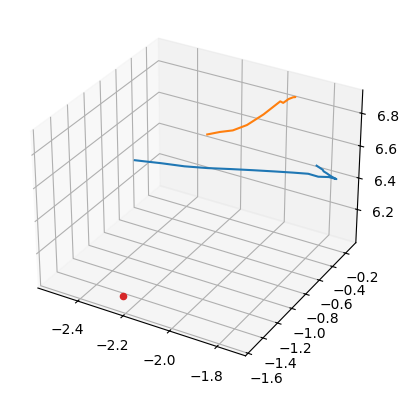

In [63]:
# Plot cube poses.  
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

smoothed_poses = np.stack([result.atPose3(X(ii)).translation() for ii in range(traj["images"].shape[0])])

# Plot the poses.
# np_cube_poses = np.array([smoothed_poses[ii].translation() for ii in range(len(smoothed_poses))])
ax.plot(smoothed_poses[:, 0], smoothed_poses[:, 1], smoothed_poses[:, 2], label='Estimated trajectory')
ax.plot(np.array([gt_pose.translation()[0] for gt_pose in gt_poses]), np.array([gt_pose.translation()[1] for gt_pose in gt_poses]), np.array([gt_pose.translation()[2] for gt_pose in gt_poses]), label='Ground truth trajectory')
ax.scatter(prior_mean.translation()[0], prior_mean.translation()[1], prior_mean.translation()[2], label='Prior', c="C3")

# Fixed-lag Smoother

In [81]:
# Pick a trajectory from the dataset.
traj_index = np.random.randint(0, dataset.num_trajectories)
traj = dataset.get_trajectory(traj_index)

# Define kubric frame rate and related dt.
kubric_fps = 12
dt = 1.0 / kubric_fps


n_steps = traj["images"].shape[0]
lag = 5 * dt

# Create a fixed-lag smoother.
smoother = gtsam_unstable.BatchFixedLagSmoother(lag)
new_factors = gtsam.NonlinearFactorGraph()
new_values = gtsam.Values()
new_timestamps = gtsam_unstable.FixedLagSmootherKeyTimestampMap()

# Setup tracking example from sim datset.
traj_index = 0
traj = dataset.get_trajectory(traj_index)

# Create a camera calibration.
intrinsics = traj["camera_intrinsics"][0]
fx = intrinsics[0, 0]
fy = intrinsics[1, 1]
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]
s = 0.0

# Create a camera calibration.
calibration = gtsam.Cal3_S2(fx, fy, s, cx, cy)

# Load ground-truth keypoints.
object_scale = traj["object_scales"][0]
keypoints_object_frame = torch.tensor(json.load(open("data/2024-01-12_17-21-39/mjc_keypoints.json"))).float() * object_scale

# Compute ground-truth initial pose.
object_pose = traj["object_poses"][0].double()
camera_pose = traj["camera_poses"][0].double()
PP_TO_GTSAM = pp.SE3(torch.cat((torch.zeros(3,), pp.euler2SO3(np.array([np.pi, 0, 0])).tensor())))
gt_pose = PP_TO_GTSAM @ camera_pose.Inv() @ object_pose

# Run inference to get predicted keypoints.
pred_keypoints = model(traj["images"]).reshape(-1, model.n_keypoints, 2)
pred_keypoints = kornia.geometry.denormalize_pixel_coordinates(pred_keypoints, model.H, model.W)
cnn_times = []

# Create noise model for the keypoint projection factor.
keypoint_noise_model = gtsam.noiseModel.Diagonal.Sigmas(5 * np.array([1e0, 1e0]))


# Create a prior on the initial position
prior_pose_cov = gtsam.noiseModel.Diagonal.Sigmas(2.5 * np.array([1e0, 1e0, 1e0, 1e0, 1e0, 1e0])) 
prior_pose_mean = gtsam.Pose3(gt_pose.matrix()).expmap(prior_pose_cov.sigmas() * np.random.randn(6))

# Create a prior on the initial position
prior_pose_factor = gtsam.PriorFactorPose3(X(0), prior_pose_mean, prior_pose_cov)
new_factors.push_back(prior_pose_factor)

# Create a prior on the initial velocity
prior_vel_cov = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
prior_vel_mean = np.zeros(3)
new_factors.push_back(gtsam.PriorFactorVector(V(0), prior_vel_mean, prior_vel_cov))

# Create a prior on the initial angular velocity
prior_ang_vel_cov = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
prior_ang_vel_mean = np.zeros(3)
new_factors.push_back(gtsam.PriorFactorVector(W(0), prior_ang_vel_mean, prior_ang_vel_cov))

# Define process noise.
process_noise_pose = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3]))
process_noise_vel = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
process_noise_ang_vel = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))

# Setup initial values and timestamps.
new_values.insert(X(0), prior_pose_mean)
new_values.insert(V(0), prior_vel_mean)
new_values.insert(W(0), prior_ang_vel_mean)
new_timestamps.insert((X(0), 0.0))
new_timestamps.insert((V(0), 0.0))
new_timestamps.insert((W(0), 0.0))

# Loop through keypoints + add factors for each one.
keypoint_factor_list = []
for kk in range(model.n_keypoints):
    # Create a keypoint projection factor.
    keypoint_factor = KeypointProjectionFactor(X(0), keypoint_noise_model, calibration, pred_keypoints[0, kk].detach().numpy(), keypoints_object_frame[kk].numpy())
    keypoint_factor_list.append(keypoint_factor)

    # Add factor to graph.
    new_factors.push_back(keypoint_factor)

# Solve the graph to start the pipeline.
smoother.update(new_factors, new_values, new_timestamps)
new_timestamps.clear()
new_factors.resize(0)
new_values.clear()

# Store the cube poses.
result = smoother.calculateEstimate()
cube_poses = [result.atPose3(X(0))]

smoother_step_times = []
result_times = []
loop_times = []

keypoint_factor_list = []

# Loop through the trajectory, add factors, and incrementally perform inference.
for tt in range(1, traj["images"].shape[0]):
    loop_start = time.time()

    cnn_start = time.time()
    model(traj["images"][tt].unsqueeze(0)).squeeze(0).reshape(-1, 2)
    cnn_times.append(time.time() - cnn_start)

    # Compute current time + add new timestamp.
    curr_time = tt * dt
    new_timestamps.insert((X(tt), curr_time))
    new_timestamps.insert((V(tt), curr_time))
    new_timestamps.insert((W(tt), curr_time))

    # Loop through keypoints + add factors for each one.
    keypoint_factor_list = []
    for kk in range(model.n_keypoints):
        # Create a keypoint projection factor.
        keypoint_factor = KeypointProjectionFactor(X(tt), keypoint_noise_model, calibration, pred_keypoints[tt, kk].detach().numpy(), keypoints_object_frame[kk].numpy())
        keypoint_factor_list.append(keypoint_factor)

        # Add factor to graph.
        new_factors.push_back(keypoint_factor)

    # Add dynamics factors.
    dynamics_factor = PoseDynamicsFactor(X(tt-1), V(tt-1), W(tt-1), X(tt), process_noise_pose, dt)
    new_factors.push_back(dynamics_factor)

    # Create a constant velocity factor and add it to the graph.
    velocity_factor = ConstantVelocityFactor(V(tt-1), V(tt), process_noise_vel)
    new_factors.push_back(velocity_factor)

    # Create a constant angular velocity factor and add it to the graph.
    angular_velocity_factor = ConstantVelocityFactor(W(tt-1), W(tt), process_noise_ang_vel)
    new_factors.push_back(angular_velocity_factor)

    # Store initial guesses for the next iteration.
    new_values.insert(X(tt), result.atPose3(X(tt-1)))
    new_values.insert(V(tt), result.atVector(V(tt-1)))
    new_values.insert(W(tt), result.atVector(W(tt-1)))

    # Compute the new estimate.
    start_smoother = time.time()
    smoother.update(new_factors, new_values, new_timestamps)
    smoother_step_times.append(time.time() - start_smoother)
    
    new_timestamps.clear()
    new_factors.resize(0)
    new_values.clear()
    
    # Store the result.
    start_result = time.time()
    result = smoother.calculateEstimate()
    result_times.append(time.time() - start_result)
    cube_poses.append(result.atPose3(X(tt)))

    loop_times.append(time.time() - loop_start)

# Store last pose.
# cube_poses.append(smoother.calculateEstimate().atPose3(X(n_steps)))
result = smoother.calculateEstimate()
final_keypoint_errors = [kk.error(result) for kk in keypoint_factor_list]

# Print some stuff.
print(f"Mean smoother step time: {np.mean(np.array(smoother_step_times))}")
print(f"Mean result time: {np.mean(np.array(result_times))}")
print(f"Mean loop time: {np.mean(np.array(loop_times))} ({1/np.mean(np.array(loop_times))} FPS)")

print(f"Mean final keypoint errors: {np.array(final_keypoint_errors).mean(axis=0)}")
print(f"Std final keypoint errors: {np.array(final_keypoint_errors).std(axis=0)}")

print(f"Mean CNN time: {np.array(cnn_times).mean()}")
# result.atPose3(X(0)), prior_mean, PP_TO_GTSAM @ camera_pose.Inv() @ object_pose

Mean smoother step time: 0.007864620374596638
Mean result time: 9.45381496263587e-06
Mean loop time: 0.0186972307122272 (53.48385626680224 FPS)
Mean final keypoint errors: 0.05358998030782456
Std final keypoint errors: 0.032818863211416076
Mean CNN time: 0.01058023908863897


In [82]:
# Plot smoothed poses vs GT using plotly.
import plotly.graph_objects as go

cube_poses_np = np.array([cube_poses[ii].translation() for ii in range(len(cube_poses))])


fig = go.Figure(data=[go.Scatter3d(x=cube_poses_np[:, 0], y=cube_poses_np[:, 1], z=cube_poses_np[:, 2], mode='lines', name='Estimated trajectory')])

# Scatter a point at the first state estimate.
fig.add_trace(go.Scatter3d(x=[cube_poses_np[0, 0]], y=[cube_poses_np[0, 1]], z=[cube_poses_np[0, 2]], mode='markers', name='Initial estimate'))

gt_poses = []
for tt in range(traj["images"].shape[0]):
    object_pose = traj["object_poses"][tt].double()
    camera_pose = traj["camera_poses"][tt].double()
    gt_poses.append(PP_TO_GTSAM @ camera_pose.Inv() @ object_pose)
gt_poses_np = np.array([gt_pose.translation() for gt_pose in gt_poses])

fig.add_trace(go.Scatter3d(x=gt_poses_np[:, 0], y=gt_poses_np[:, 1], z=gt_poses_np[:, 2], mode='lines', name='Ground truth trajectory'))

# Plot the prior.
fig.add_trace(go.Scatter3d(x=[prior_pose_mean.translation()[0]], y=[prior_pose_mean.translation()[1]], z=[prior_pose_mean.translation()[2]], mode='markers', name='Prior'))

# Set aspect ratio to be true.
fig.update_layout(scene=dict(aspectmode='data'))

fig.show()

In [80]:
def pose_diff(gt_pose:pp.SE3_type, est_pose: gtsam.Pose3) -> np.ndarray:
    est_pose = pp.mat2SE3(est_pose.matrix())
    return est_pose @ gt_pose.Inv()

print(f"Final relative pose: {pose_diff(gt_poses[-1], result.atPose3(X(n_steps-1)))}")

print(f"Prior relative pose: {pose_diff(gt_poses[0], prior_pose_mean)}")

Final relative pose: SE3Type LieTensor:
LieTensor([ 2.1744e-01, -1.1123e-02, -3.0492e-01,  3.2253e-03,  9.2590e-03,
           -9.6692e-04, -9.9995e-01], dtype=torch.float64)
Prior relative pose: SE3Type LieTensor:
LieTensor([-5.2784,  2.2824, -2.2240,  0.1989,  0.0823,  0.5532,  0.8047],
          dtype=torch.float64)


['Dim',
 'Level',
 'Project',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'backproject',
 'deserialize',
 'dim',
 'equals',
 'localCoordinates',
 'pose',
 'print',
 'project',
 'range',
 'retract',
 'serialize']